# Object detection API demo

Interactive demo for testing the dockerized object detection API.


In [3]:
import base64
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ipywidgets import widgets, interact
import io
from PIL import Image


In [4]:
# API configuration
API_URL = "http://localhost:8000"
DETECT_ENDPOINT = f"{API_URL}/detect"
HEALTH_ENDPOINT = f"{API_URL}/health"

def check_api_health():
    """Check if API is running"""
    try:
        response = requests.get(HEALTH_ENDPOINT, timeout=5)
        if response.status_code == 200:
            data = response.json()
            print(f"✓ API is healthy: {data}")
            return True
        else:
            print(f"✗ API returned status {response.status_code}")
            return False
    except requests.exceptions.RequestException as e:
        print(f"✗ Cannot connect to API: {e}")
        return False

# Check API health
check_api_health()


✓ API is healthy: {'status': 'healthy', 'model_loaded': True}


True

In [5]:
def encode_image_to_base64(image_path):
    """Convert image file to base64 string"""
    with open(image_path, "rb") as image_file:
        encoded = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded

def decode_base64_to_image(base64_string):
    """Convert base64 string to numpy array"""
    image_data = base64.b64decode(base64_string)
    image_array = np.frombuffer(image_data, dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def call_detection_api(image_path, confidence_threshold=0.25):
    """Call the detection API with an image"""
    try:
        # Encode image
        image_b64 = encode_image_to_base64(image_path)
        
        # Prepare request
        payload = {
            "image": image_b64,
            "confidence_threshold": confidence_threshold
        }
        
        # Call API
        response = requests.post(DETECT_ENDPOINT, json=payload, timeout=30)
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"API error: {response.status_code} - {response.text}")
            return None
            
    except Exception as e:
        print(f"Error calling API: {e}")
        return None


In [6]:
def display_results(image_path, result, confidence_threshold):
    """Display original image, annotated image, and detection results"""
    if result is None:
        print("No results to display")
        return
    
    # Load original image
    original_img = cv2.imread(image_path)
    original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # Decode annotated image
    annotated_img = decode_base64_to_image(result['annotated_image'])
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Display original image
    ax1.imshow(original_img_rgb)
    ax1.set_title('Original image')
    ax1.axis('off')
    
    # Display annotated image
    ax2.imshow(annotated_img)
    ax2.set_title(f'Detections (threshold: {confidence_threshold})')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detection details
    print(f"Processing time: {result['processing_time_ms']:.1f} ms")
    print(f"Found {len(result['detections'])} objects:")
    print("-" * 60)
    
    for i, detection in enumerate(result['detections']):
        bbox = detection['bbox']
        print(f"{i+1:2d}. {detection['class_name']} "
              f"({detection['confidence']:.3f}) - "
              f"{detection['color_name']} - "
              f"bbox: [{bbox[0]}, {bbox[1]}, {bbox[2]}, {bbox[3]}]")

# File upload widget
file_upload = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload image'
)

# Confidence threshold slider
confidence_slider = widgets.FloatSlider(
    value=0.25,
    min=0.05,
    max=0.95,
    step=0.05,
    description='Confidence:',
    style={'description_width': 'initial'}
)

# Button to run detection
run_button = widgets.Button(
    description='Run detection',
    button_style='success'
)

# Display widgets
display(file_upload)
display(confidence_slider)
display(run_button)


FileUpload(value=(), accept='image/*', description='Upload image')

FloatSlider(value=0.25, description='Confidence:', max=0.95, min=0.05, step=0.05, style=SliderStyle(descriptio…

Button(button_style='success', description='Run detection', style=ButtonStyle())

In [7]:
def on_run_detection(button):
    """Handle detection button click"""
    if not file_upload.value:
        print("Please upload an image first")
        return
    
    # Save uploaded file temporarily
    uploaded_file = list(file_upload.value.values())[0]
    temp_path = f"/tmp/{uploaded_file['metadata']['name']}"
    
    with open(temp_path, 'wb') as f:
        f.write(uploaded_file['content'])
    
    print(f"Running detection on {uploaded_file['metadata']['name']}...")
    print(f"Confidence threshold: {confidence_slider.value}")
    
    # Call API
    result = call_detection_api(temp_path, confidence_slider.value)
    
    # Display results
    if result:
        display_results(temp_path, result, confidence_slider.value)
    
    # Clean up temp file
    import os
    os.remove(temp_path)

# Connect button to handler
run_button.on_click(on_run_detection)


## Test with sample images

You can also test with existing validation images:


Sample images available:
1. Explorer_HD2K_SN36949228_13-52-02_L.png
2. Explorer_HD2K_SN36949228_13-30-45_R.png
3. Explorer_HD2K_SN36949228_09-46-32_R.png
4. Explorer_HD2K_SN36949228_11-01-38_R.png
5. Explorer_HD2K_SN36949228_16-04-08_R.png

Testing with Explorer_HD2K_SN36949228_13-52-02_L.png:


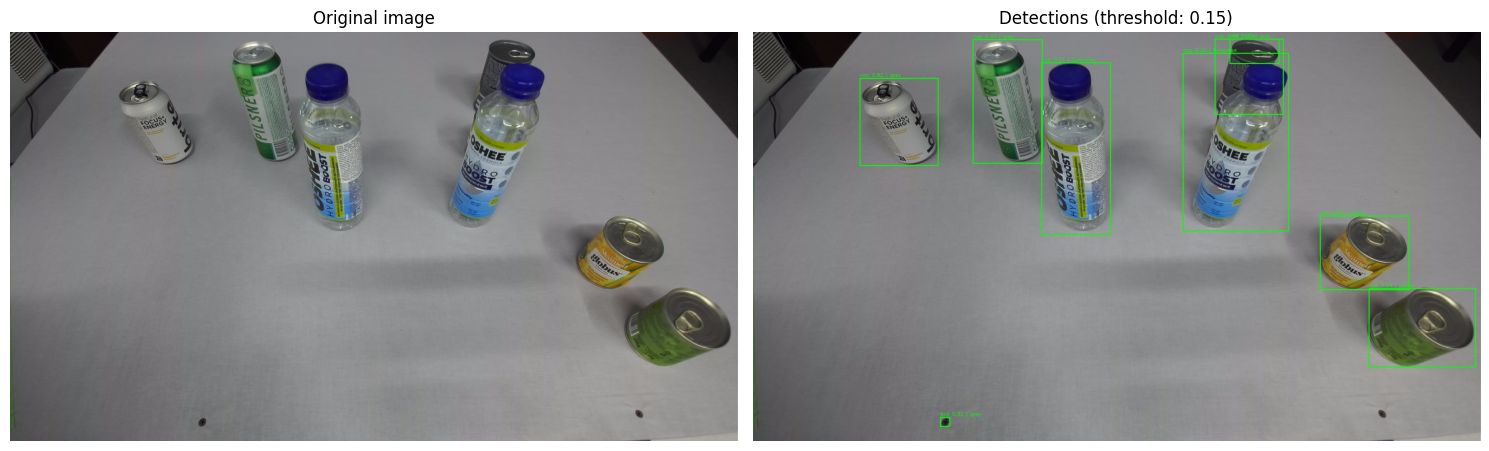

Processing time: 14.2 ms
Found 9 objects:
------------------------------------------------------------
 1. can (0.949) - yellow - bbox: [1720, 560, 1989, 783]
 2. can (0.942) - yellow - bbox: [1868, 780, 2191, 1017]
 3. can (0.824) - grey - bbox: [324, 143, 561, 407]
 4. cup (0.492) - blue - bbox: [1401, 24, 1608, 252]
 5. cup (0.371) - grey - bbox: [667, 26, 877, 400]
 6. ball (0.321) - grey - bbox: [568, 1170, 597, 1197]
 7. ball (0.299) - grey - bbox: [1446, 24, 1595, 98]
 8. cup (0.225) - turquoise - bbox: [1304, 67, 1624, 605]
 9. cup (0.211) - turquoise - bbox: [875, 96, 1084, 616]


In [11]:
import os
import glob

# Path to validation images
VAL_IMAGES_DIR = '/home/ut-ai/ai-works/adaptibot/yolo_detect/dataset/images/val'

if os.path.exists(VAL_IMAGES_DIR):
    sample_images = glob.glob(os.path.join(VAL_IMAGES_DIR, '*.png'))[:5]
    
    if sample_images:
        print("Sample images available:")
        for i, img_path in enumerate(sample_images):
            print(f"{i+1}. {os.path.basename(img_path)}")
        
        # Test with first sample image
        if len(sample_images) > 0:
            print(f"\nTesting with {os.path.basename(sample_images[0])}:")
            result = call_detection_api(sample_images[0], 0.15)
            if result:
                display_results(sample_images[0], result, 0.15)
    else:
        print("No PNG images found in validation directory")
else:
    print(f"Validation directory not found: {VAL_IMAGES_DIR}")


## Interactive threshold testing

Test different confidence thresholds on the same image:


Testing thresholds on Explorer_HD2K_SN36949228_13-52-02_L.png

Testing threshold 0.1...
Found 10 objects

Testing threshold 0.15...
Found 9 objects

Testing threshold 0.2...
Found 9 objects

Testing threshold 0.25...
Found 7 objects

Testing threshold 0.3...
Found 6 objects

Testing threshold 0.35...
Found 5 objects

Testing threshold 0.4...
Found 4 objects

Testing threshold 0.45...
Found 4 objects

Testing threshold 0.5...
Found 3 objects


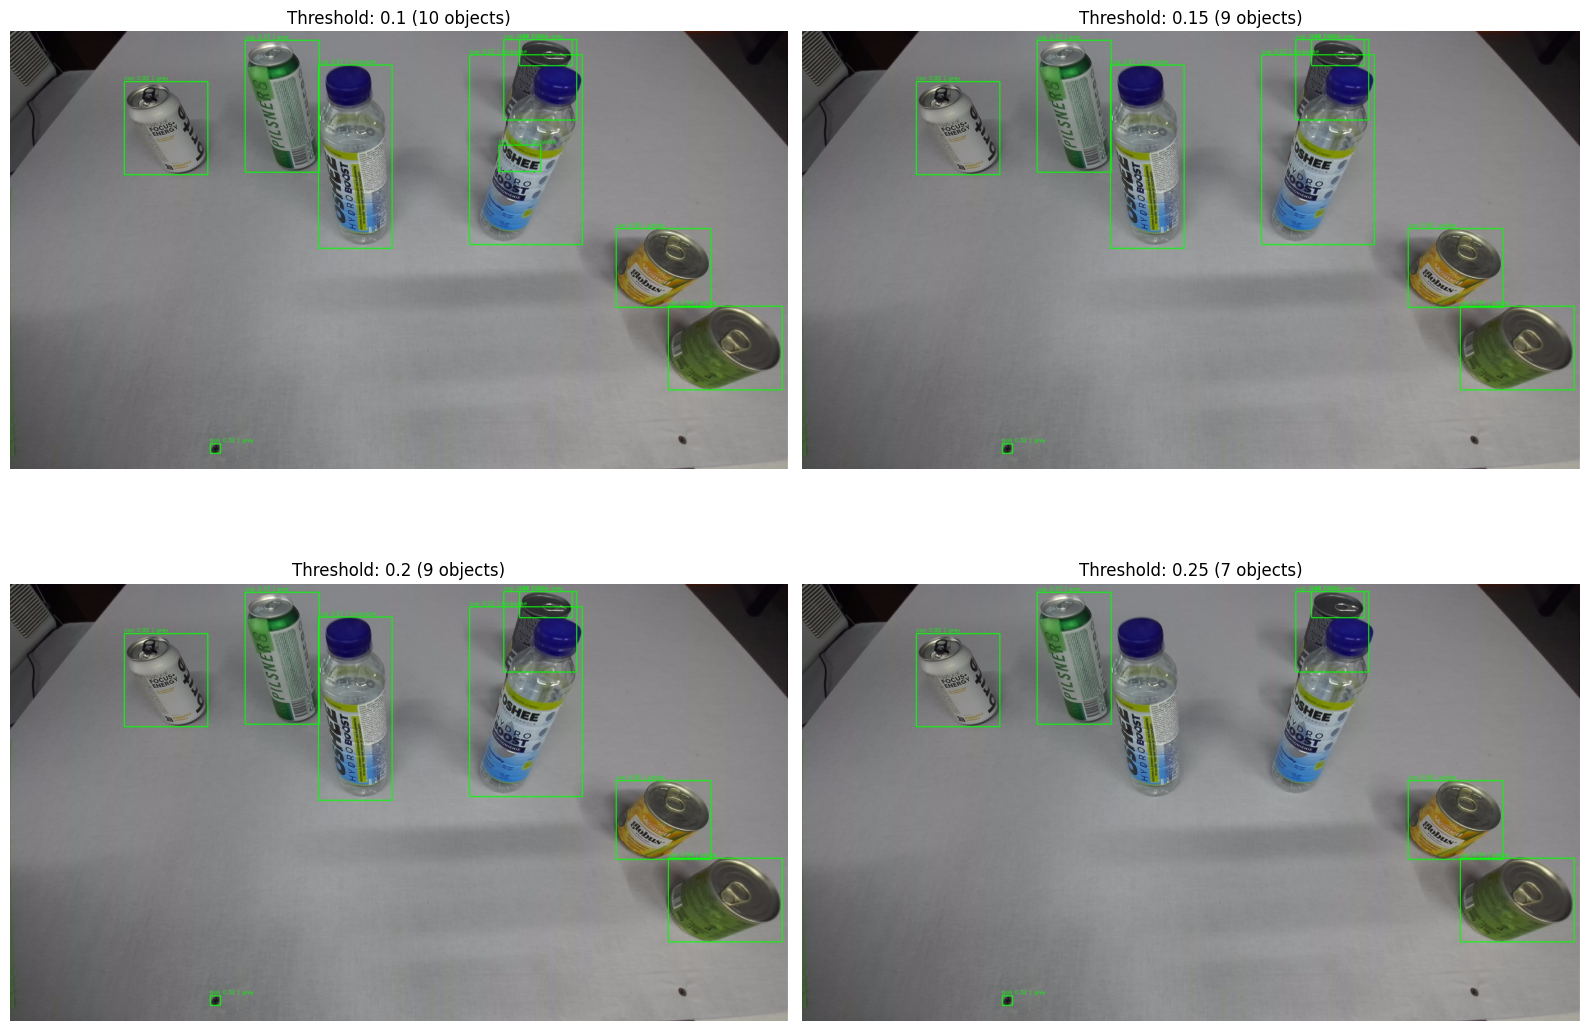

In [ ]:
def test_thresholds(image_path, thresholds=[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]):
    """Test multiple confidence thresholds on the same image"""
    print(f"Testing thresholds on {os.path.basename(image_path)}")
    
    results = {}
    for threshold in thresholds:
        print(f"\nTesting threshold {threshold}...")
        result = call_detection_api(image_path, threshold)
        if result:
            results[threshold] = result
            print(f"Found {len(result['detections'])} objects")
    
    # Display comparison
    if results:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        for i, (threshold, result) in enumerate(results.items()):
            if i < 4:  # Max 4 subplots
                annotated_img = decode_base64_to_image(result['annotated_image'])
                axes[i].imshow(annotated_img)
                axes[i].set_title(f'Threshold: {threshold} ({len(result["detections"])} objects)')
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Test with sample image if available
if 'sample_images' in locals() and sample_images:
    test_thresholds(sample_images[0])
